## Step 1: Load data & packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df_berlin_grouped = pd.read_csv('berlin_grouped.csv').drop(columns='Unnamed_0')
df_berlin_grouped.head(2)

,serviceCharge,heatingType,newlyConst,balcony,telekomUploadSpeed,totalRent,yearConstructed,scoutId,hasKitchen,cellar,...,numberOfFloors,garden,regio3,heatingCosts,ParkSpaces,fullAddress,bezirk,bezirk_group,flat_group,condition_group
0,205.0,district_heating,0,0,40.0,1209.0,1920,115446359,0,0,...,5,0,Charlottenburg_Charlottenburg,87.8,0,"Kaiserdamm 4, 14057 Berlin, Germany",Charlottenburg,West,Ground Floor,Renovated
1,78.0,central_heating,0,0,40.0,529.0,1920,105798745,0,0,...,7,0,Charlottenburg_Charlottenburg,26.0,0,"Pascalstr. 3, 10587 Berlin, Germany",Charlottenburg,West,Apartment,Renovated


In [6]:
df_berlin_grouped.shape

(8861, 28)

In [7]:
df_berlin_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8861 entries, 0 to 8860
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   serviceCharge       8861 non-null   float64
 1   heatingType         8861 non-null   object 
 2   newlyConst          8861 non-null   int64  
 3   balcony             8861 non-null   int64  
 4   telekomUploadSpeed  8861 non-null   float64
 5   totalRent           8861 non-null   float64
 6   yearConstructed     8861 non-null   int64  
 7   scoutId             8861 non-null   int64  
 8   hasKitchen          8861 non-null   int64  
 9   cellar              8861 non-null   int64  
 10  baseRent            8861 non-null   float64
 11  livingSpace         8861 non-null   float64
 12  condition           8861 non-null   object 
 13  petsAllowed         8861 non-null   int64  
 14  lift                8861 non-null   int64  
 15  typeOfFlat          8861 non-null   object 
 16  noRoom

# Encoding Bezirk
Since the area in which the flat is plays a role on the price of the flat.

In [9]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df_berlin_grouped[['bezirk_group', 'flat_group', 'condition_group']])

# the labels
ohe.categories_

[array(['Central', 'East', 'North', 'South', 'West'], dtype=object),
 array(['Apartment', 'Ground Floor', 'Maisonette/Duplex', 'Roof Storey'],
       dtype=object),
 array(['Needs Work', 'New', 'Renovated', 'Well-maintained'], dtype=object)]

In [10]:
columns_encoded = list(ohe.get_feature_names_out(['bezirk_group', 'flat_group', 'condition_group']))

In [11]:
columns_encoded

['bezirk_group_Central',
 'bezirk_group_East',
 'bezirk_group_North',
 'bezirk_group_South',
 'bezirk_group_West',
 'flat_group_Apartment',
 'flat_group_Ground Floor',
 'flat_group_Maisonette/Duplex',
 'flat_group_Roof Storey',
 'condition_group_Needs Work',
 'condition_group_New',
 'condition_group_Renovated',
 'condition_group_Well-maintained']

In [12]:
df_berlin_grouped[columns_encoded] = ohe.transform(df_berlin_grouped[['bezirk_group', 'flat_group', 'condition_group']])

In [13]:
df_berlin_grouped = df_berlin_grouped.drop(columns=['bezirk_group', 'flat_group', 'condition_group'])

# Selecting features

<Axes: >

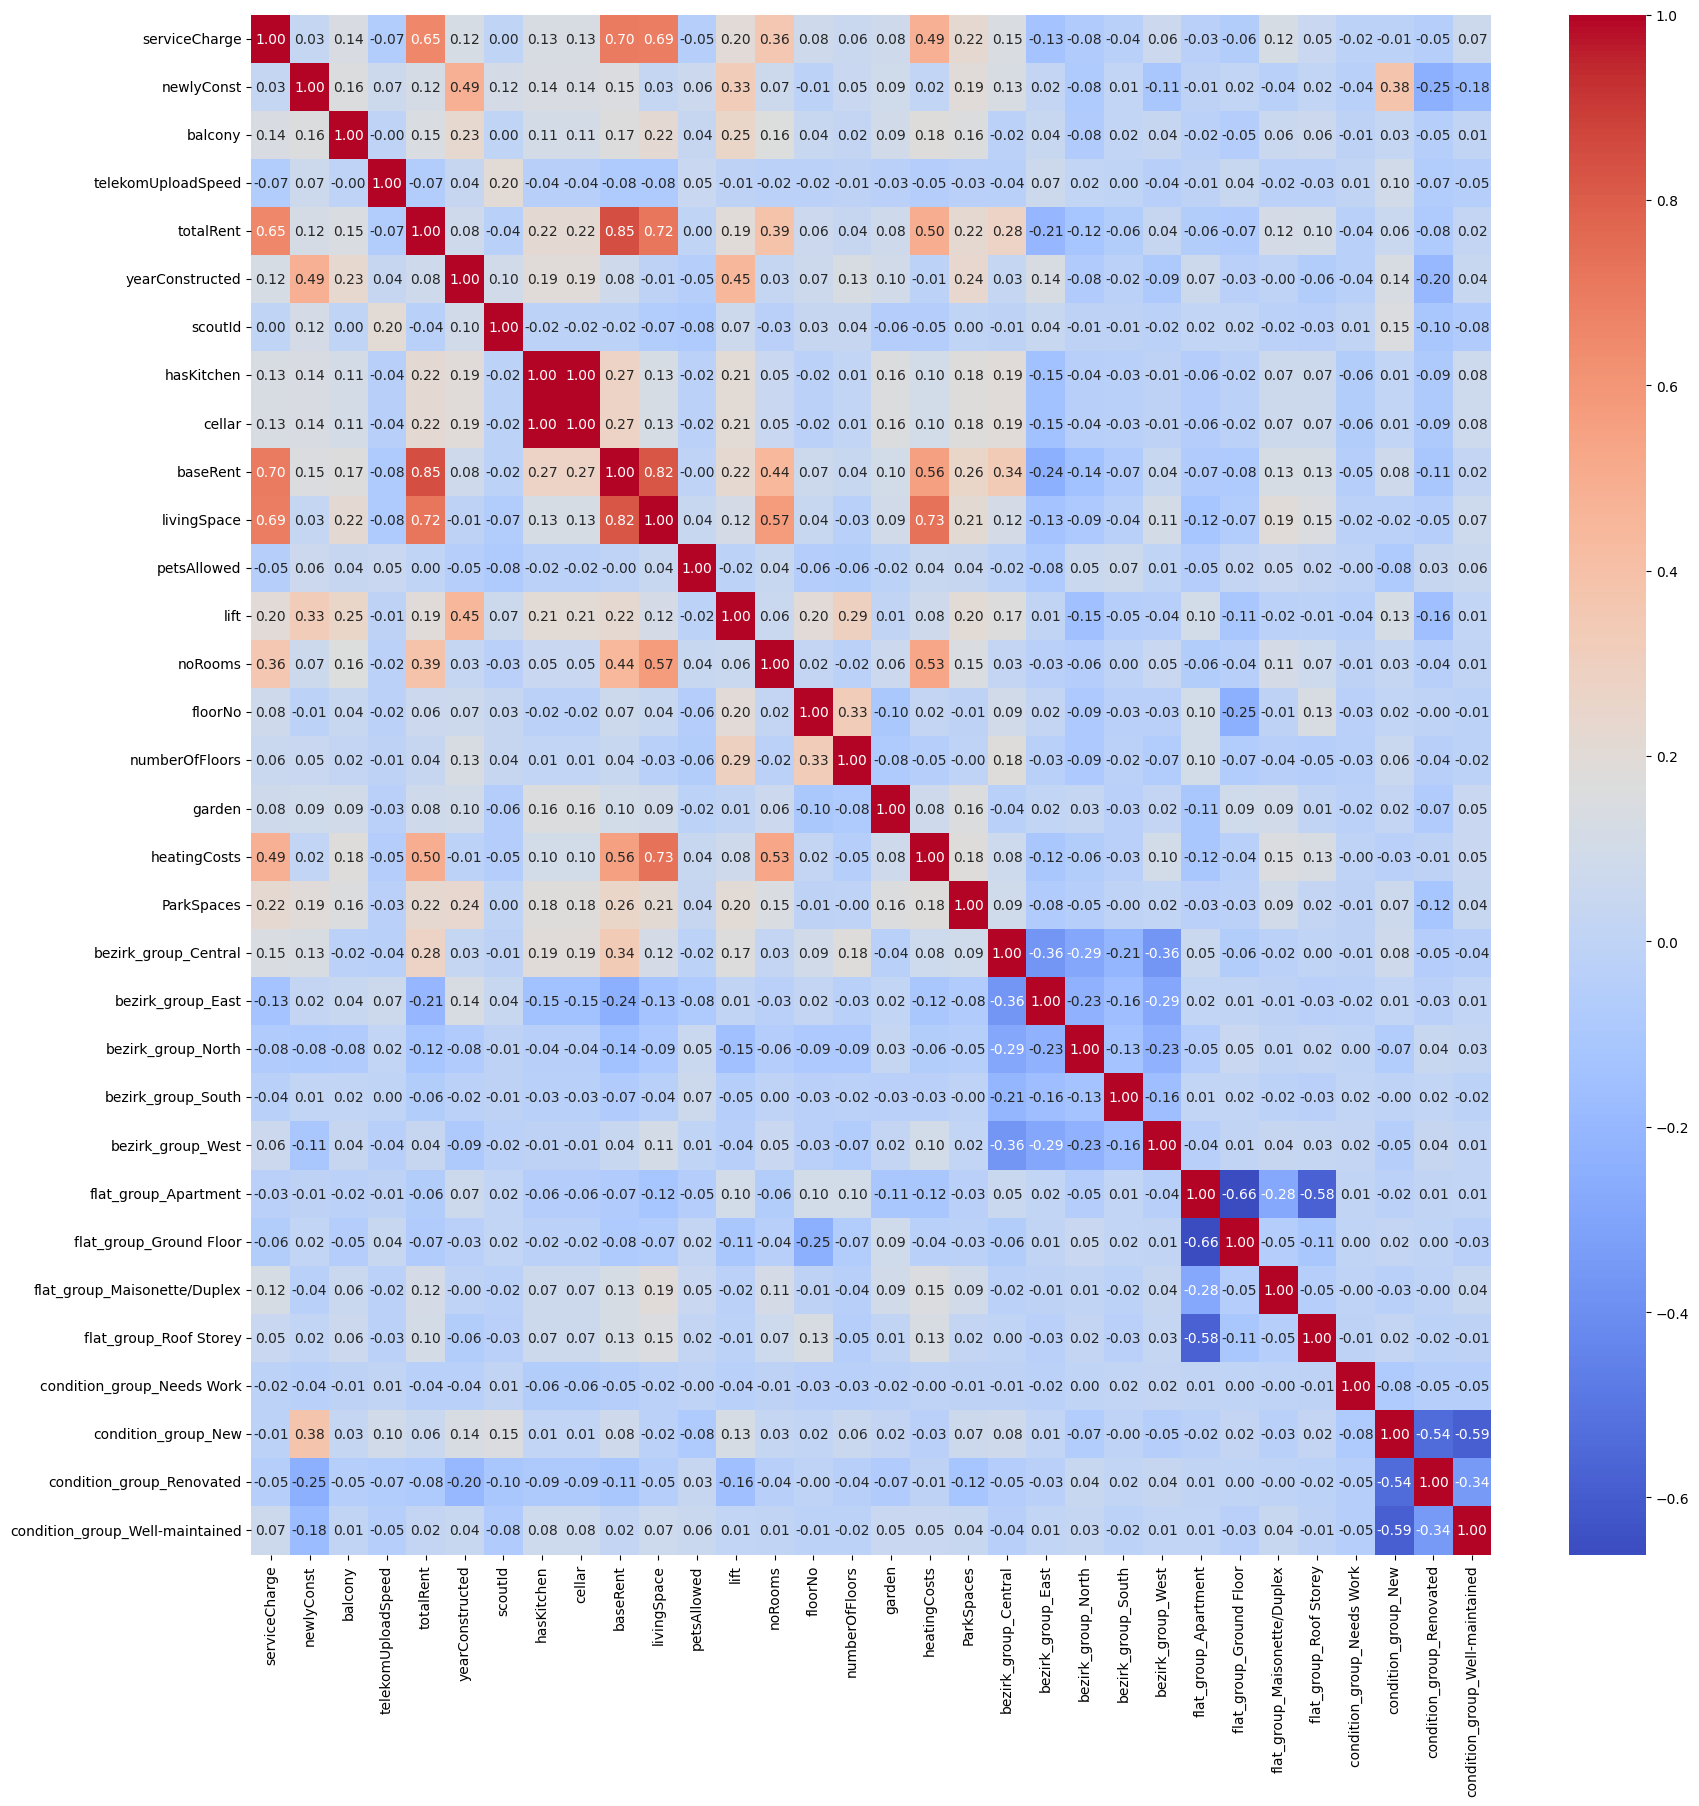

In [14]:
num_features = df_berlin_grouped.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(20,20))
sns.heatmap(num_features.corr(), annot=True, fmt=".2f", cmap='coolwarm')

## Step 2: Feature Engineering

In [15]:
average_price = df_berlin_grouped['baseRent'].mean()

df_berlin_grouped['price_category'] = np.where(df_berlin_grouped['baseRent'] > average_price, 'above_average',
                                np.where(df_berlin_grouped['baseRent'] < average_price, 'below_average', 'at_average'))

df_berlin_grouped['price_category'].value_counts()

price_category
below_average    5435
above_average    3426
Name: count, dtype: int64

## Step 3: Data Preprocessing

In [17]:
# Features: You can include more features if you want
features = ['scoutId', 'serviceCharge', 'yearConstructed', 'hasKitchen', 'cellar', 'livingSpace', 'noRooms', 'heatingCosts',
            'ParkSpaces', 'bezirk_group_Central', 'bezirk_group_East', 'bezirk_group_North', 'bezirk_group_South',
            'bezirk_group_West', 'price_category']
X = df_berlin_grouped[features]

Data vizualisation to see, which scalling methods works best and what needs to be dropped

Text(0.5, 1.0, 'bezirk_group_West')

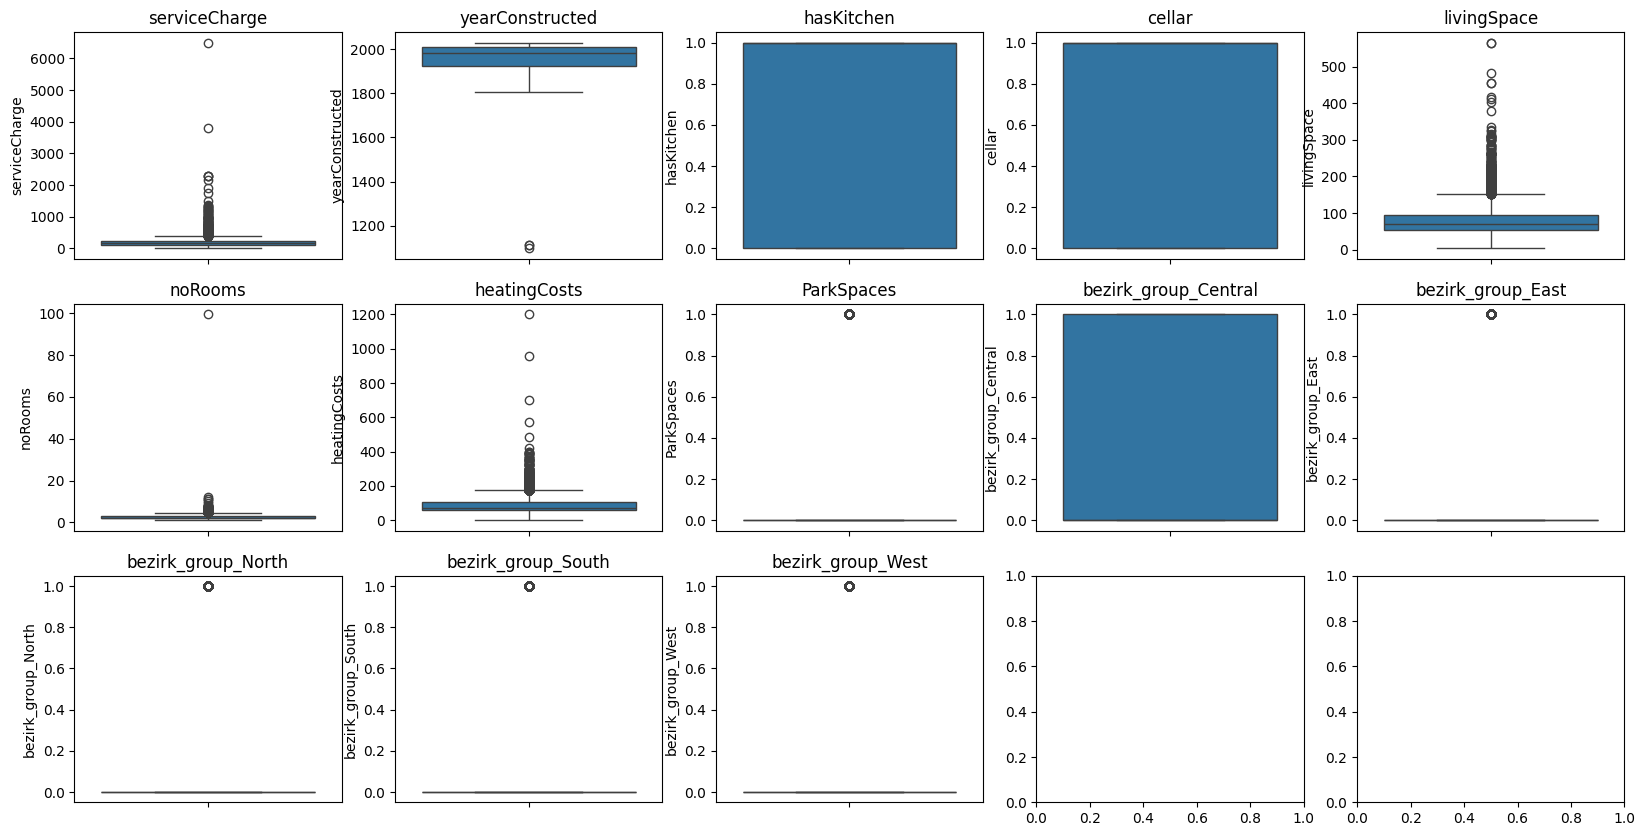

In [19]:
fig, axs = plt.subplots(3, 5, figsize=(20,10))

sns.boxplot(data=X['serviceCharge'], ax=axs[0, 0])
axs[0, 0].set_title('serviceCharge')

sns.boxplot(data=X['yearConstructed'], ax=axs[0, 1])
axs[0, 1].set_title('yearConstructed')

sns.boxplot(data=X['hasKitchen'], ax=axs[0, 2])
axs[0, 2].set_title('hasKitchen')

sns.boxplot(data=X['cellar'], ax=axs[0, 3])
axs[0, 3].set_title('cellar')

sns.boxplot(data=X['livingSpace'], ax=axs[0, 4])
axs[0, 4].set_title('livingSpace')

sns.boxplot(data=X['noRooms'], ax=axs[1, 0])
axs[1, 0].set_title('noRooms')

sns.boxplot(data=X['heatingCosts'], ax=axs[1, 1])
axs[1, 1].set_title('heatingCosts')

sns.boxplot(data=X['ParkSpaces'], ax=axs[1, 2])
axs[1, 2].set_title('ParkSpaces')

sns.boxplot(data=X['bezirk_group_Central'], ax=axs[1, 3])
axs[1, 3].set_title('bezirk_group_Central')

sns.boxplot(data=X['bezirk_group_East'], ax=axs[1, 4])
axs[1, 4].set_title('bezirk_group_East')

sns.boxplot(data=X['bezirk_group_North'], ax=axs[2, 0])
axs[2, 0].set_title('bezirk_group_North')

sns.boxplot(data=X['bezirk_group_South'], ax=axs[2, 1])
axs[2, 1].set_title('bezirk_group_South')

sns.boxplot(data=X['bezirk_group_West'], ax=axs[2, 2])
axs[2, 2].set_title('bezirk_group_West')

#sns.boxenplot()
#plt.show();

Dropping the few samples with nonesense values is better than MinMaxScaler, since the prices in the housing market
depends on the outliers.

In [20]:
to_drop = X.loc[X['serviceCharge'] == 6500]
X.drop(X[X['serviceCharge'] == 6500].index, inplace=True)

/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/4104877476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X[X['serviceCharge'] == 6500].index, inplace=True)


In [21]:
X['yearConstructed'].min()
#X.loc[X['yearConstructed'] == 2029]
#X.loc[X['yearConstructed'] <= 1800]
X.drop(X[X['yearConstructed'] <= 1800].index, inplace=True)

/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/3565946855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X[X['yearConstructed'] <= 1800].index, inplace=True)


In [22]:
X.drop(X[X['noRooms'] >= 50].index, inplace=True)

/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/2853302382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X[X['noRooms'] >= 50].index, inplace=True)


In [23]:
X.drop(X[X['heatingCosts'] >= 800].index, inplace=True)

/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/4198300502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(X[X['heatingCosts'] >= 800].index, inplace=True)


In [24]:
# Standardize feature variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[['serviceCharge', 'yearConstructed', 'noRooms', 'livingSpace', 'heatingCosts']])
X[['serviceCharge', 'yearConstructed', 'noRooms', 'livingSpace', 'heatingCosts']] = X_scaled

/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/502154441.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['serviceCharge', 'yearConstructed', 'noRooms', 'livingSpace', 'heatingCosts']] = X_scaled


In [25]:
X

,scoutId,serviceCharge,yearConstructed,hasKitchen,cellar,livingSpace,noRooms,heatingCosts,ParkSpaces,bezirk_group_Central,bezirk_group_East,bezirk_group_North,bezirk_group_South,bezirk_group_West,price_category
0,115446359,0.121796,-1.114476,0,0,0.061816,0.005238,0.039722,0,0.0,0.0,0.0,0.0,1.0,below_average
1,105798745,-0.801594,-1.114476,0,0,-1.075515,-1.408650,-1.296967,0,0.0,0.0,0.0,0.0,1.0,below_average
2,115688647,0.046398,-1.114476,0,0,-0.485834,-0.466058,0.063515,0,0.0,0.0,0.0,0.0,1.0,below_average
3,110815256,-0.641637,-1.114476,0,0,-0.263491,0.476534,-0.258762,0,0.0,0.0,0.0,0.0,1.0,below_average
4,115199030,-0.387159,-1.114476,0,0,0.063059,-0.466058,-0.237132,0,1.0,0.0,0.0,0.0,0.0,below_average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,113786954,-0.983364,0.333066,1,1,-0.814623,-0.466058,-0.669718,0,0.0,1.0,0.0,0.0,0.0,below_average
8857,115704953,-1.128780,0.333066,0,0,-1.148883,-1.408650,-1.015786,0,0.0,1.0,0.0,0.0,0.0,below_average
8858,107377611,-0.005007,0.333066,1,1,1.299127,2.361717,-0.198200,0,1.0,0.0,0.0,0.0,0.0,above_average
8859,113034613,0.994291,0.333066,1,1,0.368221,0.476534,1.493210,0,0.0,0.0,0.0,0.0,1.0,above_average


In [26]:
y = X['price_category']
X_y = X.drop(columns=['price_category', 'scoutId'])

In [27]:
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_y, y, test_size=0.2, random_state=42)

## Step 4: Model Training
we will test 3 different models and choose the best performing model.

### RandomForest

In [28]:
# Initiate Random Forest classifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test only
y_pred = model.predict(X_test)


In [29]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 570   96]
 [  82 1023]]

Classification Report:
               precision    recall  f1-score   support

above_average       0.87      0.86      0.86       666
below_average       0.91      0.93      0.92      1105

     accuracy                           0.90      1771
    macro avg       0.89      0.89      0.89      1771
 weighted avg       0.90      0.90      0.90      1771



### KNN

In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

In [31]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, knn_y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, knn_y_pred))

Confusion Matrix:
[[ 553  113]
 [ 100 1005]]

Classification Report:
               precision    recall  f1-score   support

above_average       0.85      0.83      0.84       666
below_average       0.90      0.91      0.90      1105

     accuracy                           0.88      1771
    macro avg       0.87      0.87      0.87      1771
 weighted avg       0.88      0.88      0.88      1771



### LogisticRegression

In [32]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
lg_y_pred = lg.predict(X_test)

In [33]:
# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, lg_y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, lg_y_pred))

Confusion Matrix:
[[ 548  118]
 [  98 1007]]

Classification Report:
               precision    recall  f1-score   support

above_average       0.85      0.82      0.84       666
below_average       0.90      0.91      0.90      1105

     accuracy                           0.88      1771
    macro avg       0.87      0.87      0.87      1771
 weighted avg       0.88      0.88      0.88      1771



In [34]:
# Predict on the entire dataset (? check this)
y_all_pred = model.predict(X_y)

# Add the predictions to the original dataframes
X['price_category_pred'] = y_all_pred


/var/folders/x6/x7vmzkqd5t7flv8bzhdtksv00000gn/T/ipykernel_45346/1414055250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price_category_pred'] = y_all_pred


In [35]:
X

,scoutId,serviceCharge,yearConstructed,hasKitchen,cellar,livingSpace,noRooms,heatingCosts,ParkSpaces,bezirk_group_Central,bezirk_group_East,bezirk_group_North,bezirk_group_South,bezirk_group_West,price_category,price_category_pred
0,115446359,0.121796,-1.114476,0,0,0.061816,0.005238,0.039722,0,0.0,0.0,0.0,0.0,1.0,below_average,below_average
1,105798745,-0.801594,-1.114476,0,0,-1.075515,-1.408650,-1.296967,0,0.0,0.0,0.0,0.0,1.0,below_average,below_average
2,115688647,0.046398,-1.114476,0,0,-0.485834,-0.466058,0.063515,0,0.0,0.0,0.0,0.0,1.0,below_average,below_average
3,110815256,-0.641637,-1.114476,0,0,-0.263491,0.476534,-0.258762,0,0.0,0.0,0.0,0.0,1.0,below_average,below_average
4,115199030,-0.387159,-1.114476,0,0,0.063059,-0.466058,-0.237132,0,1.0,0.0,0.0,0.0,0.0,below_average,below_average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856,113786954,-0.983364,0.333066,1,1,-0.814623,-0.466058,-0.669718,0,0.0,1.0,0.0,0.0,0.0,below_average,below_average
8857,115704953,-1.128780,0.333066,0,0,-1.148883,-1.408650,-1.015786,0,0.0,1.0,0.0,0.0,0.0,below_average,below_average
8858,107377611,-0.005007,0.333066,1,1,1.299127,2.361717,-0.198200,0,1.0,0.0,0.0,0.0,0.0,above_average,above_average
8859,113034613,0.994291,0.333066,1,1,0.368221,0.476534,1.493210,0,0.0,0.0,0.0,0.0,1.0,above_average,above_average


## Step 6: Save to a new df

In [36]:
X[['scoutId', 'price_category_pred']].to_csv('updated_apartment_data_with_predictions.csv', index=False)

In [37]:
df_predictions = pd.read_csv("updated_apartment_data_with_predictions.csv")

In [38]:
df_predictions.shape

(8854, 2)

In [39]:
df_predictions.head()

,scoutId,price_category_pred
0,115446359,below_average
1,105798745,below_average
2,115688647,below_average
3,110815256,below_average
4,115199030,below_average
